In [1]:
from pycocotools.coco import COCO
import numpy as np
import random
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from skimage.transform import resize
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
annFile='coco/annotations_trainval2017/annotations/instances_train2017.json'

In [3]:
coco=COCO(annFile)

loading annotations into memory...
Done (t=9.66s)
creating index...
index created!


In [4]:
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)
img_Ids = coco.getImgIds(catIds=44)

In [5]:
len(img_Ids)

8501

In [20]:
img = coco.loadImgs(img_Ids[400])[0]

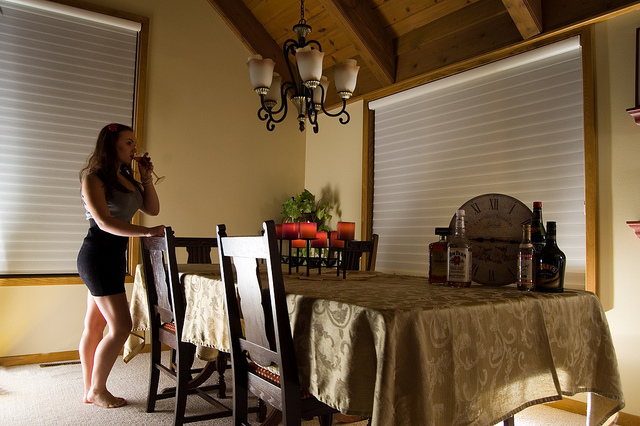

In [21]:
img_file = img['file_name']
Image.open(f'coco/train2017/{img_file}')

In [22]:
annIds = coco.getAnnIds(imgIds=img['id'], catIds=44)
anns = coco.loadAnns(annIds)

In [30]:
len(anns)

4

In [33]:
mask = np.zeros((img['height'],img['width']))

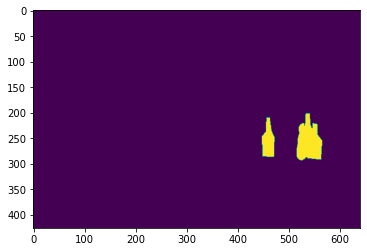

In [34]:
for i in range(len(anns)):
    mask = np.maximum(coco.annToMask(anns[i]), mask)
plt.imshow(mask)

In [6]:
from toarchvision import datasets, models, transforms
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms

In [55]:
class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, img_id, coco):
        'Initialization'
        self.img_id = img_id
        self.coco = coco
        self.transform_img = transforms.Compose([
            transforms.Resize((240,240)),
            #transforms.CenterCrop(528),
            transforms.ColorJitter(hue=.05, saturation=.05),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.img_id)

    def __getitem__(self, index):
        'Generates one sample of data'
        img = self.coco.loadImgs(self.img_id[index])[0]
        annIds = self.coco.getAnnIds(imgIds=img['id'], catIds=44)
        anns = self.coco.loadAnns(annIds)
        img_file = img['file_name']
        image = Image.open(f'coco/train2017/{img_file}').convert('RGB')
        image = self.transform_img(image)
        mask = np.zeros((img['height'],img['width']))
        mask = np.maximum(self.coco.annToMask(anns[0]), mask)
        mask = torch.tensor(resize(mask, (240,240)), dtype=torch.float).unsqueeze(0)
        return image, mask


In [56]:
train_imgIds, val_imgIds = train_test_split(img_Ids, test_size=0.15)

In [57]:
train_dataset = Dataset(train_imgIds, coco)
val_dataset = Dataset(val_imgIds, coco)

In [58]:
train_loader = DataLoader(train_dataset, batch_size=6, num_workers=os.cpu_count(),
        drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=6, num_workers=os.cpu_count(),
        drop_last=True)

In [17]:
class SegmentationNet(nn.Module):
    def __init__(self):
        super(SegmentationNet, self).__init__()
        self.segnet = smp.DeepLabV3Plus(encoder_name="efficientnet-b1", encoder_weights="imagenet", in_channels=3, classes=1)
    def forward(self, x):
        x = self.segnet(x)
        return x

In [60]:
net = SegmentationNet().cuda()

In [61]:
EPOCHS = 10
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

In [62]:
from tqdm import tqdm

In [65]:
best_loss = 1e8
for i in range(EPOCHS):
    total_loss = 0
    
    '''
    net.train()
    print("***Train***")
    for image, mask in tqdm(train_loader):
        output_mask = net(image.cuda())
        loss = criterion(output_mask, mask.cuda())
        total_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(i, total_loss.item())
    net.eval()
    total_loss = 0
    '''
    print("***Validation***")
    with torch.no_grad():
        for image, mask in val_loader:
            output_mask = net(image.cuda())
            loss = criterion(output_mask, mask.cuda())
            total_loss += loss
    val_loss = total_loss.item()
    print(val_loss)
    if val_loss<best_loss:
        torch.save(net.state_dict(),"model.pth")

***Validation***
9.524726867675781
***Validation***


KeyboardInterrupt: 